# Problem 4: Understanding the Impact of Attention Mechanisms

In this assignment, we will:
- Build a Convolutional Neural Network (CNN) to classify images from the Reduced MNIST dataset.
- Build a second CNN with a spatial attention mechanism.
- Compare the two models based on accuracy and training time.
- Visualize the results using plots and attention map visualizations.
- Explore a creative improvement idea.

The Reduced MNIST dataset is a subset of the original MNIST dataset, with grayscale images (28x28 pixels) of digits 0-9, organized in folders by class.

In [5]:
import numpy as np
import cv2
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Input, 
                                     Multiply, GlobalAveragePooling2D, GlobalMaxPooling2D, 
                                     Add, Activation, Reshape,MultiHeadAttention,LayerNormalization,Dropout)

os.environ["CUDA_VISIBLE_DEVICES"] = ""
# Set random seed for reproducibility
tf.random.set_seed(4)
np.random.seed(4)

### Load and Preprocess Data


In [6]:
# Define paths to training and testing data directories
train_data_dir = '../../Assignment2/part1/Reduced MNIST Data/Reduced Training data'
test_data_dir = '../../Assignment2/part1/Reduced MNIST Data/Reduced Testing data'

# Get list of subdirectories (each representing a digit class)
train_class_dirs = os.listdir(train_data_dir)
test_class_dirs = os.listdir(test_data_dir)

print("Training class directories:", train_class_dirs)
print("Testing class directories:", test_class_dirs)

# Initialize lists to store images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training data
for digit_class in train_class_dirs:
    class_path = os.path.join(train_data_dir, digit_class)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        train_images.append(image)
        train_labels.append(int(digit_class))  # Convert string label to integer

# Load testing data
for digit_class in test_class_dirs:
    class_path = os.path.join(test_data_dir, digit_class)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        test_images.append(image)
        test_labels.append(int(digit_class))

# Convert lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Shuffle training and testing data for randomness
train_images, train_labels = shuffle(train_images, train_labels, random_state=4)
test_images, test_labels = shuffle(test_images, test_labels, random_state=4)

# Normalize images to [0,1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add channel dimension for CNN input (28, 28, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Print shapes to verify
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Training class directories: ['0', '7', '5', '2', '6', '8', '4', '9', '3', '1']
Testing class directories: ['0', '7', '5', '2', '6', '8', '4', '9', '3', '1']
Training images shape: (10000, 28, 28, 1)
Training labels shape: (10000,)
Testing images shape: (2000, 28, 28, 1)
Testing labels shape: (2000,)


## Base CNN Model

This model is a standard CNN without an attention mechanism:
- 2 convolutional layers with ReLU activation and max-pooling.
- A flatten layer followed by dense layers.
- Output layer with softmax for 10-class classification.

In [7]:
# Build the base CNN model
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model1.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model1.summary()

/home/rero/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## CNN with Spatial Attention

This model adds a spatial attention mechanism:
- After the first Conv2D and MaxPooling2D, an attention map is generated using a 1x1 convolution with sigmoid activation.
- The attention map is multiplied with the feature maps to emphasize important regions.
- The architecture then continues similarly to the base CNN.

In [8]:
# Build the CNN model with spatial attention using Functional API
input_layer = Input(shape=(28,28,1))
x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D((2,2))(x)

# Spatial attention mechanism
attention = Conv2D(1, (1,1), activation='sigmoid')(x)  # Attention map (14,14,1)
x = Multiply()([x, attention])  # Apply attention to feature maps (14,14,32)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(10, activation='softmax')(x)

model2 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 26, 26,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 13, 13,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 13, 13, 1) │         33 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 13, 13,    │          0 │ max_pooling2d_6[… │
│ (Multiply)          │ 32)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 11, 11,    │     18,496 │ multiply_1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 5, 5, 64)  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1600)      │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │    204,928 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │      1,290 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 225,067 (879.17 KB)

 Trainable params: 225,067 (879.17 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Models

We train both models for 10 epochs with a batch size of 32, using the test set as validation data to monitor performance. Training time is recorded for comparison.

In [9]:
# Train the base CNN
start_time = time.time()
history1 = model1.fit(train_images, train_labels, epochs=10, batch_size=32, 
                     validation_data=(test_images, test_labels), verbose=1)
end_time = time.time()
training_time1 = end_time - start_time
print(f"Training time for Base CNN: {training_time1:.2f} seconds")

Epoch 1/10


2025-04-09 21:13:05.592119: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7487 - loss: 0.8114 - val_accuracy: 0.9695 - val_loss: 0.1006
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9638 - loss: 0.1287 - val_accuracy: 0.9830 - val_loss: 0.0541
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9775 - loss: 0.0785 - val_accuracy: 0.9850 - val_loss: 0.0483
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9862 - loss: 0.0510 - val_accuracy: 0.9830 - val_loss: 0.0544
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9905 - loss: 0.0372 - val_accuracy: 0.9810 - val_loss: 0.0564
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9916 - loss: 0.0310 - val_accuracy: 0.9845 - val_loss: 0.0499
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9942 - loss: 0.0225 - val_accuracy: 0.9820 - val_loss: 0.0591
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9956 - loss: 0.0184 - val_accuracy: 0.985

In [10]:
# Train the CNN with attention
start_time = time.time()
history2 = model2.fit(train_images, train_labels, epochs=10, batch_size=32, 
                     validation_data=(test_images, test_labels), verbose=1)
end_time = time.time()
training_time2 = end_time - start_time
print(f"Training time for CNN with Attention: {training_time2:.2f} seconds")

Epoch 1/10


2025-04-09 21:13:46.990740: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


 14/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.1751 - loss: 2.2427 

2025-04-09 21:13:47.891991: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30349696 exceeds 10% of free system memory.
2025-04-09 21:13:47.892065: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30349696 exceeds 10% of free system memory.
2025-04-09 21:13:47.909652: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30349696 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6953 - loss: 0.9444 - val_accuracy: 0.9655 - val_loss: 0.1199
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9494 - loss: 0.1789 - val_accuracy: 0.9840 - val_loss: 0.0598
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9632 - loss: 0.1219 - val_accuracy: 0.9800 - val_loss: 0.0518
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9708 - loss: 0.0960 - val_accuracy: 0.9820 - val_loss: 0.0451
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9770 - loss: 0.0744 - val_accuracy: 0.9845 - val_loss: 0.0428
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9813 - loss: 0.0607 - val_accuracy: 0.9870 - val_loss: 0.0433
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9840 - loss: 0.0529 - val_accuracy: 0.9835 - val_loss: 0.0561
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9867 - loss: 0.0467 - val_accuracy: 0.985

## Comparing Accuracy and Training Time

We plot training and validation accuracy for both models and evaluate their test accuracy.

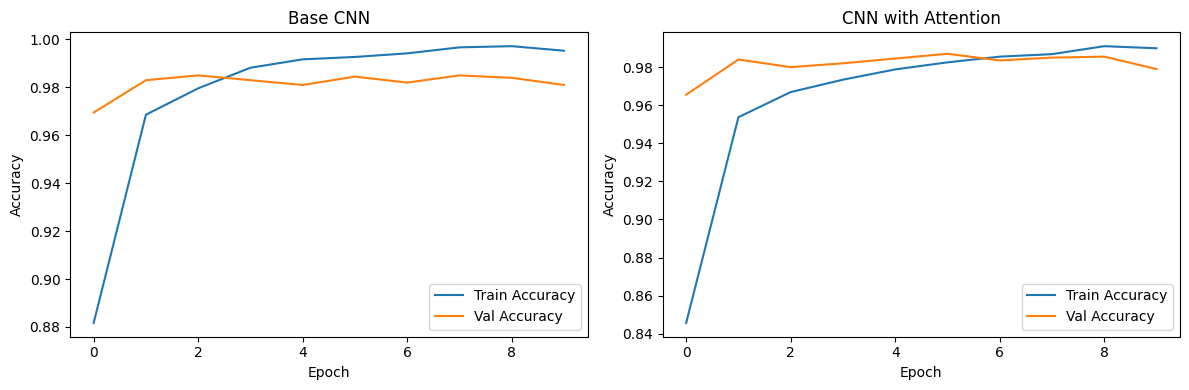

In [11]:
# Plot accuracy curves
plt.figure(figsize=(12, 4))

# Base CNN
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Base CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# CNN with Attention
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN with Attention')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Evaluate both models on the test set
test_loss1, test_acc1 = model1.evaluate(test_images, test_labels, verbose=0)
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels, verbose=0)

print(f"Test accuracy for Base CNN: {test_acc1:.4f}")
print(f"Test accuracy for CNN with Attention: {test_acc2:.4f}")
print(f"Training time difference (Attention - Base): {training_time2 - training_time1:.2f} seconds")

Test accuracy for Base CNN: 0.9810
Test accuracy for CNN with Attention: 0.9790
Training time difference (Attention - Base): 6.90 seconds


In [13]:
print(f"\nTraining time for Base CNN: {training_time1:.2f} seconds")
print(f"\nTraining time for CNN model with spatial attention: {training_time2:.2f} seconds")


Training time for Base CNN: 41.41 seconds

Training time for CNN model with spatial attention: 48.30 seconds


## Visualizing Attention Maps

We visualize the attention maps from the second model for a few test images to see where it focuses.

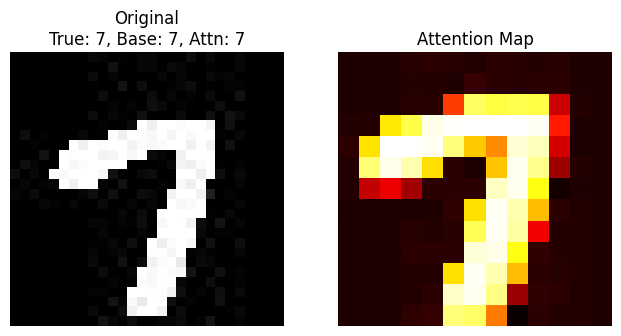

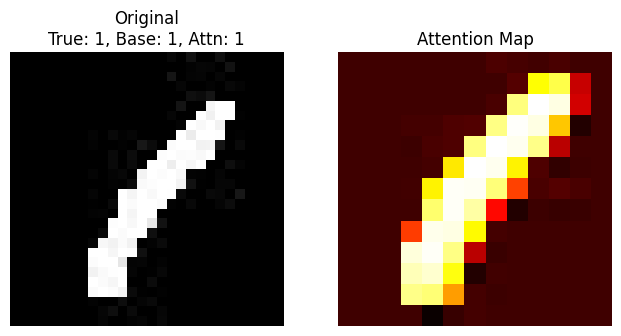

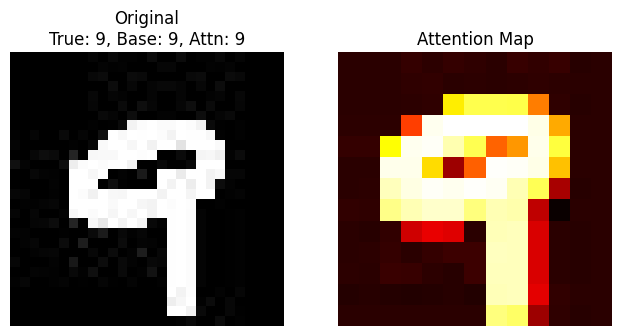

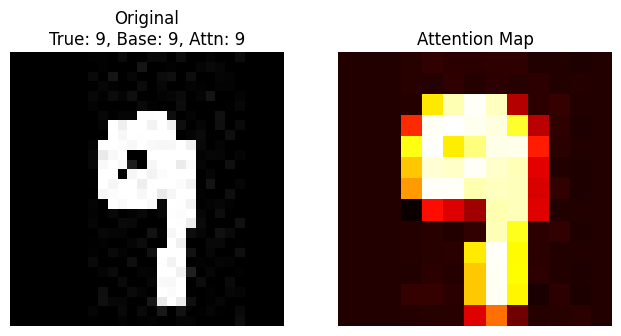

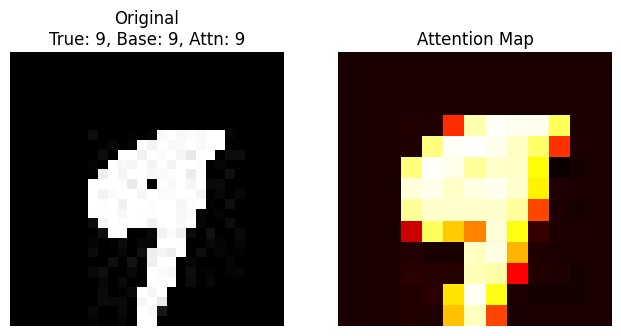

In [14]:
# Create a submodel to output the attention map
attention_model = Model(inputs=model2.input, outputs=model2.layers[3].output)

# Select 5 random test images
num_images = 5
indices = np.random.choice(len(test_images), num_images, replace=False)

for i in indices:
    test_image = test_images[i:i+1]  # Add batch dimension
    true_label = test_labels[i]
    pred_label1 = np.argmax(model1.predict(test_image, verbose=0))
    pred_label2 = np.argmax(model2.predict(test_image, verbose=0))
    attention_map = attention_model.predict(test_image, verbose=0)[0, :, :, 0]  # Shape (14,14)

    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title(f'Original\nTrue: {true_label}, Base: {pred_label1}, Attn: {pred_label2}')
    plt.axis('off')
    
    # Attention map
    plt.subplot(1, 3, 2)
    plt.imshow(attention_map, cmap='hot')
    plt.title('Attention Map')
    plt.axis('off')
    
    plt.show()

## Creative Improvement Idea: CNN with Self-Attention

This model combines a CNN backbone with a self-attention mechanism:
- **CNN Backbone**: Extracts initial features from 28x28 images.
- **Self-Attention**: Applies multi-head self-attention to model long-range dependencies across the image.
- **Output**: Classifies digits into 10 classes.

We’ll train the model, evaluate its accuracy, visualize attention maps, and compare it with previous models.

In [15]:
# Build the CNN model with self-attention
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)  # Output: (26, 26, 32)
x = MaxPooling2D((2, 2))(x)  # Output: (13, 13, 32)
x = Conv2D(64, (3, 3), activation='relu')(x)  # Output: (11, 11, 64)
x = MaxPooling2D((2, 2))(x)  # Output: (5, 5, 64)

# Reshape for self-attention: treat each spatial location as a token
num_patches = 5 * 5  # 25 patches from (5, 5, 64)
x = Reshape((num_patches, 64))(x)  # Output: (25, 64)

# Apply multi-head self-attention
attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)  # Output: (25, 64)
x = LayerNormalization()(attention_output + x)  # Residual connection and normalization

# Pooling and classification
x = Flatten()(x)  # Output: (1600,)
x = Dense(128, activation='relu')(x)  # Output: (128,)
x = Dropout(0.3)(x)
output_layer = Dense(10, activation='softmax')(x)  # Output: (10,)

# Create the model
model_self_attn = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_self_attn.compile(optimizer=Adam(), 
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])

# Display model summary
print("Model Summary:")
model_self_attn.summary()

Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 26, 26,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 13, 13,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 11, 11,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 5, 5, 64)  │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 25, 64)    │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 25, 64)    │     66,368 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 25, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 25, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1600)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │    204,928 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │      1,290 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 291,530 (1.11 MB)

 Trainable params: 291,530 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
start_time = time.time()
history_self_attn = model_self_attn.fit(train_images, train_labels, 
                                        epochs=10, 
                                        batch_size=32, 
                                        validation_data=(test_images, test_labels), 
                                        verbose=1)
end_time = time.time()
training_time_self_attn = end_time - start_time


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.7513 - loss: 0.7745 - val_accuracy: 0.9795 - val_loss: 0.0763
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9523 - loss: 0.1570 - val_accuracy: 0.9770 - val_loss: 0.0644
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9710 - loss: 0.0870 - val_accuracy: 0.9845 - val_loss: 0.0482
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9825 - loss: 0.0622 - val_accuracy: 0.9900 - val_loss: 0.0404
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9874 - loss: 0.0426 - val_accuracy: 0.9885 - val_loss: 0.0428
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9867 - loss: 0.0417 - val_accuracy: 0.9865 - val_loss: 0.0517
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9913 - loss: 0.0301 - val_accuracy: 0.9825 - val_loss: 0.0570
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9903 - loss: 0.0311 - val_acc

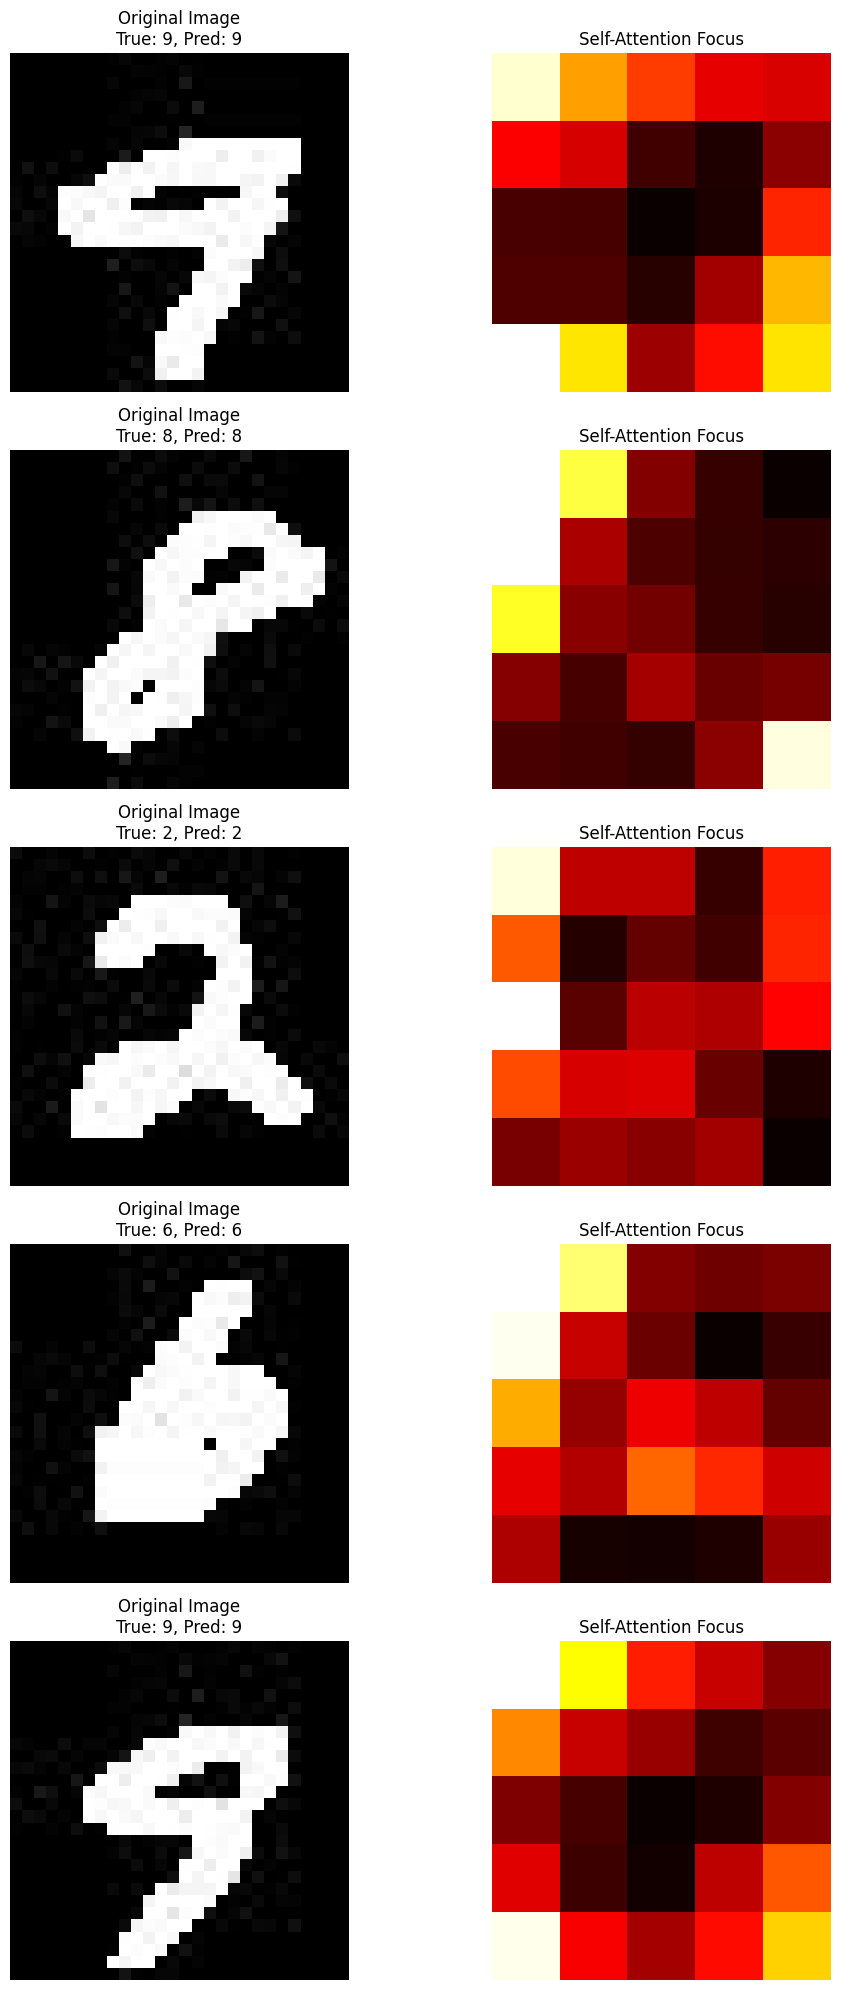

In [17]:
# Create a submodel to output the attention weights
attention_layer = model_self_attn.layers[6]  # MultiHeadAttention layer (adjust index if needed)
attention_model = Model(inputs=model_self_attn.input, 
                        outputs=attention_layer.output)

# Select 5 random test images
num_images = 5
indices = np.random.choice(len(test_images), num_images, replace=False)

plt.figure(figsize=(15, 4 * num_images))
for idx, i in enumerate(indices):
    test_image = test_images[i:i+1]  # Add batch dimension
    true_label = test_labels[i]
    pred_label = np.argmax(model_self_attn.predict(test_image, verbose=0))
    attn_output = attention_model.predict(test_image, verbose=0)  # Shape: (1, 25, 64)
    
    # Get attention weights (requires accessing internal attention scores)
    # Note: MultiHeadAttention doesn't directly output weights; we simulate focus with output magnitude
    attn_weights = np.mean(attn_output[0], axis=-1)  # Average across feature dims: (25,)
    attn_weights = attn_weights.reshape(5, 5)  # Reshape to spatial grid

    # Original image
    plt.subplot(num_images, 3, 3 * idx + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image\nTrue: {true_label}, Pred: {pred_label}')
    plt.axis('off')
    
    # Attention map (simplified)
    plt.subplot(num_images, 3, 3 * idx + 2)
    plt.imshow(attn_weights, cmap='hot')
    plt.title('Self-Attention Focus')
    plt.axis('off')

plt.tight_layout()
plt.show()

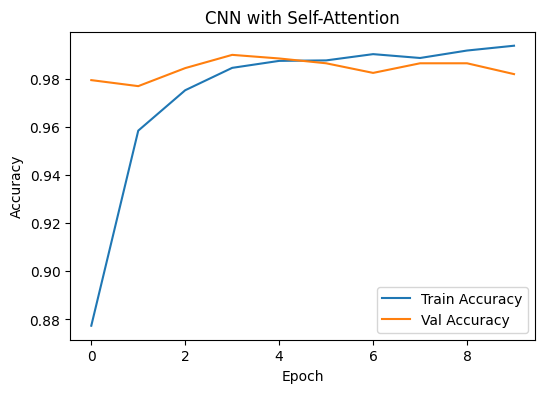

In [18]:
# Plot accuracy curves
plt.figure(figsize=(6, 4))
plt.plot(history_self_attn.history['accuracy'], label='Train Accuracy')
plt.plot(history_self_attn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN with Self-Attention')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Evaluate the model
test_loss_self_attn, test_acc_self_attn = model_self_attn.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy for CNN with Self-Attention: {test_acc_self_attn:.4f}")
print(f"\nTraining time for CNN with Self-Attention: {training_time_self_attn:.2f} seconds")

Test accuracy for CNN with Self-Attention: 0.9820

Training time for CNN with Self-Attention: 80.55 seconds


## CNN with CBAM (Channel and Spatial Attention) and Regularization

This model implements a hybrid attention mechanism using CBAM (Convolutional Block Attention Module):
- **Channel Attention**: Focuses on "what" features are important using global pooling and a shared MLP.
- **Spatial Attention**: Focuses on "where" in the image using a convolutional layer.
- **Regularization**: Adds dropout (0.3) after the dense layer to mitigate overfitting.

We’ll train the model, evaluate its accuracy, visualize attention maps, and compare it with previous models.

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Multiply, GlobalAveragePooling2D, GlobalMaxPooling2D, Add, Activation, Reshape, Dropout, Layer
from tensorflow.keras.models import Model
import tensorflow as tf

def channel_attention_cbam(input_feature, ratio=8):
    """
    Implements channel attention for CBAM.
    Args:
        input_feature: Input tensor of shape (batch_size, height, width, channels)
        ratio: Reduction ratio for the dense layers (default=8)
    Returns:
        Tensor with channel attention applied
    """
    channel = input_feature.shape[-1]
    
    # Shared MLP layers
    shared_layer_one = Dense(channel // ratio, activation='relu')
    shared_layer_two = Dense(channel)
    
    # Global average pooling
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    # Global max pooling
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    # Combine and apply sigmoid
    attention = Add()([avg_pool, max_pool])
    attention = Activation('sigmoid')(attention)
    
    return Multiply()([input_feature, attention])

class SpatialAttentionCBAM(Layer):
    """
    Custom Keras layer for CBAM spatial attention.
    """
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttentionCBAM, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = Conv2D(1, (kernel_size, kernel_size), padding='same', activation='sigmoid')

    def build(self, input_shape):
        super(SpatialAttentionCBAM, self).build(input_shape)

    def call(self, inputs):
        # Compute channel-wise average and max
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate and apply convolution
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        
        return inputs * attention

    def compute_output_shape(self, input_shape):
        return input_shape

def cbam_block(input_feature, ratio=8):
    """
    Combines channel and spatial attention in a CBAM block.
    Args:
        input_feature: Input tensor
        ratio: Reduction ratio for channel attention
    Returns:
        Tensor with CBAM attention applied
    """
    x = channel_attention_cbam(input_feature, ratio)
    x = SpatialAttentionCBAM(kernel_size=7)(x)
    return x

In [21]:
# Build the CNN model with CBAM and dropout
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)  # Output: (26, 26, 32)
x = MaxPooling2D((2, 2))(x)  # Output: (13, 13, 32)

# Apply CBAM block
x = cbam_block(x)  # Output: (13, 13, 32)

# Extract spatial attention map for visualization using the custom layer
# First, apply channel attention to match the CBAM block's internal steps
x_for_viz = channel_attention_cbam(x)  # Output: (13, 13, 32)
# Then, apply spatial attention and extract the attention map
spatial_att_layer = SpatialAttentionCBAM(kernel_size=7)
spatial_att_map = spatial_att_layer(x_for_viz)  # Output: (13, 13, 32)
# Reduce to (13, 13, 1) for visualization by taking the mean across channels
class ReduceMeanLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=-1, keepdims=True)
spatial_att_map = ReduceMeanLayer()(spatial_att_map)  # Output: (13, 13, 1)

x = Conv2D(64, (3, 3), activation='relu')(x)  # Output: (11, 11, 64)
x = MaxPooling2D((2, 2))(x)  # Output: (5, 5, 64)
x = Flatten()(x)  # Output: (1600,)
x = Dense(128, activation='relu')(x)  # Output: (128,)
x = Dropout(0.3)(x)  # Add dropout for regularization
output_layer = Dense(10, activation='softmax')(x)  # Output: (10,)

# Create the model
model_cbam = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_cbam.compile(optimizer=Adam(), 
                   loss='sparse_categorical_crossentropy', 
                   metrics=['accuracy'])

# Display model summary
print("Model Summary:")
model_cbam.summary()

Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 26, 26,    │        320 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 13, 13,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_10… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ max_pooling2d_10… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1, 4)   │        132 │ reshape_1[0][0],  │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_9[0][0],    │
│                     │                   │            │ dense_9[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1, 32)  │          0 │ dense_10[0][0],   │
│                     │                   │            │ dense_10[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1, 32)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 13, 13,    │          0 │ max_pooling2d_10… │
│ (Multiply)          │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention_… │ (None, 13, 13,    │          0 │ multiply_2[0][0]  │
│ (SpatialAttentionC… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 11, 11,    │     18,496 │ spatial_attentio… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 5, 5, 64)  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1600)      │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │    204,928 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 225,326 (880.18 KB)

 Trainable params: 225,326 (880.18 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
start_time = time.time()
history_cbam = model_cbam.fit(train_images, train_labels, 
                              epochs=10, 
                              batch_size=32, 
                              validation_data=(test_images, test_labels), 
                              verbose=1)
end_time = time.time()
training_time_cbam = end_time - start_time


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6580 - loss: 1.0340 - val_accuracy: 0.9660 - val_loss: 0.1084
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9447 - loss: 0.1920 - val_accuracy: 0.9740 - val_loss: 0.0752
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9653 - loss: 0.1240 - val_accuracy: 0.9835 - val_loss: 0.0541
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9727 - loss: 0.0970 - val_accuracy: 0.9800 - val_loss: 0.0583
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9772 - loss: 0.0744 - val_accuracy: 0.9865 - val_loss: 0.0434
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9825 - loss: 0.0622 - val_accuracy: 0.9825 - val_loss: 0.0548
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9837 - loss: 0.0498 - val_accuracy: 0.9850 - val_loss: 0.0505
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9873 - loss: 0.0458 - val_accu

In [23]:
# Evaluate the model
test_loss_cbam, test_acc_cbam = model_cbam.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy for CNN with CBAM: {test_acc_cbam:.4f}")
print(f"\nTraining time for CNN with CBAM: {training_time_cbam:.2f} seconds")

Test accuracy for CNN with CBAM: 0.9830

Training time for CNN with CBAM: 63.40 seconds


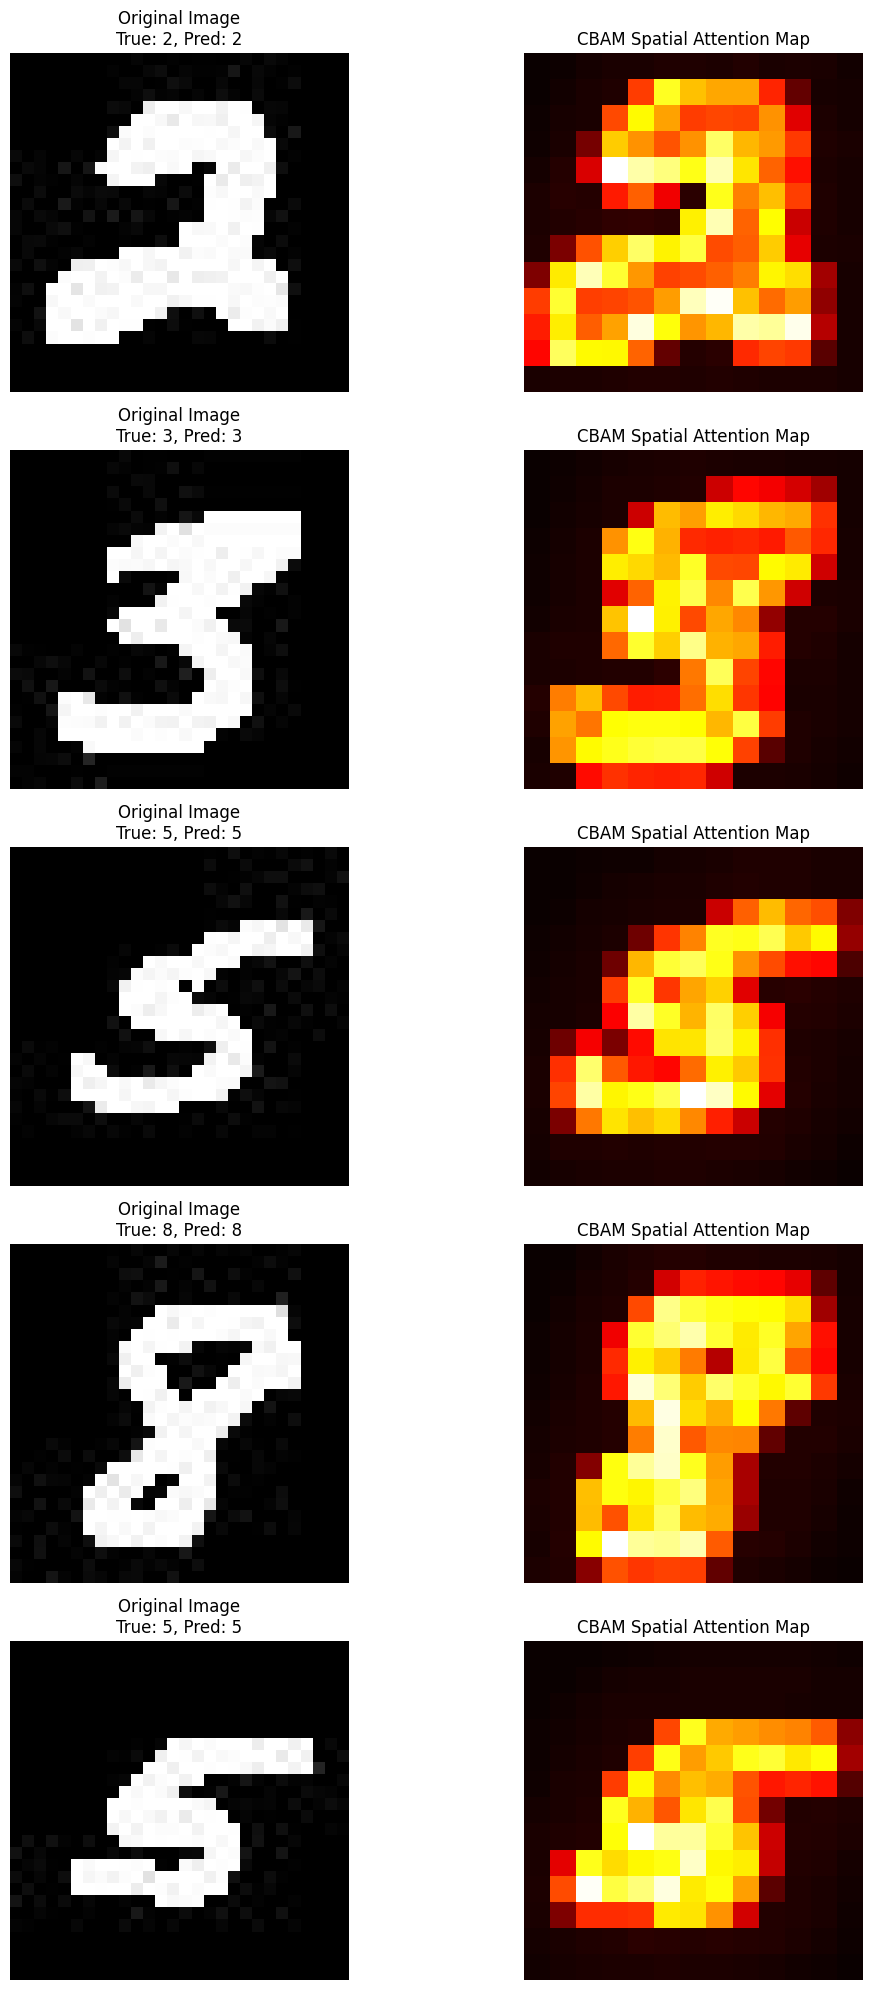

In [24]:
# Create a submodel to output the spatial attention map
attention_model_cbam = Model(inputs=input_layer, outputs=spatial_att_map)

# Select 5 random test images
num_images = 5
indices = np.random.choice(len(test_images), num_images, replace=False)

plt.figure(figsize=(12, 4 * num_images))
for idx, i in enumerate(indices):
    test_image = test_images[i:i+1]  # Add batch dimension
    true_label = test_labels[i]
    pred_label = np.argmax(model_cbam.predict(test_image, verbose=0))
    attention_map = attention_model_cbam.predict(test_image, verbose=0)[0, :, :, 0]  # Shape: (13, 13)

    # Original image
    plt.subplot(num_images, 2, 2 * idx + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title(f'Original Image\nTrue: {true_label}, Pred: {pred_label}')
    plt.axis('off')
    
    # Spatial attention map
    plt.subplot(num_images, 2, 2 * idx + 2)
    plt.imshow(attention_map, cmap='hot')
    plt.title('CBAM Spatial Attention Map')
    plt.axis('off')

plt.tight_layout()
plt.show()

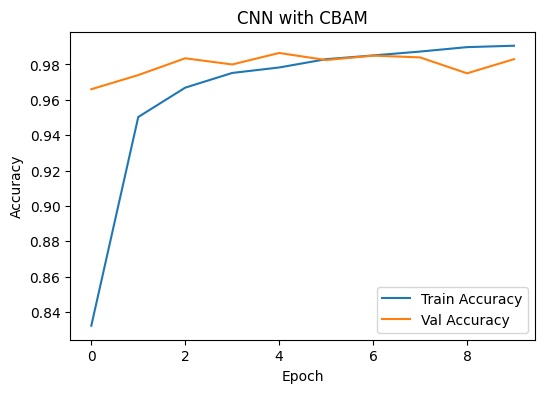

In [25]:
# Plot accuracy curves
plt.figure(figsize=(6, 4))
plt.plot(history_cbam.history['accuracy'], label='Train Accuracy')
plt.plot(history_cbam.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN with CBAM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN with Squeeze-and-Excitation (SE) Channel Attention and Regularization

This model implements channel attention using the Squeeze-and-Excitation (SE) mechanism:
- **Squeeze**: Uses global average pooling to summarize each channel.
- **Excitation**: Applies a small neural network to compute channel weights, reweighting the feature maps.
- **Regularization**: Adds dropout (0.3) after the dense layer to mitigate overfitting.

We’ll train the model, evaluate its accuracy, and compare it with previous models. Since SE focuses on channel attention, we won’t visualize spatial attention maps (as there’s no spatial attention component).

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Multiply, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

def se_block(input_feature, ratio=8):
    """
    Implements Squeeze-and-Excitation (SE) channel attention.
    Args:
        input_feature: Input tensor of shape (batch_size, height, width, channels)
        ratio: Reduction ratio for the dense layers (default=8)
    Returns:
        Tensor with SE channel attention applied
    """
    channel = input_feature.shape[-1]
    
    # Squeeze: Global average pooling
    squeeze = GlobalAveragePooling2D()(input_feature)
    squeeze = Reshape((1, 1, channel))(squeeze)
    
    # Excitation: Two dense layers
    excitation = Dense(channel // ratio, activation='relu')(squeeze)
    excitation = Dense(channel, activation='sigmoid')(excitation)
    
    # Scale the input feature maps
    return Multiply()([input_feature, excitation])

In [27]:
# Build the CNN model with SE channel attention and dropout
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)  # Output: (26, 26, 32)
x = MaxPooling2D((2, 2))(x)  # Output: (13, 13, 32)

# Apply SE block
x = se_block(x, ratio=8)  # Output: (13, 13, 32)

x = Conv2D(64, (3, 3), activation='relu')(x)  # Output: (11, 11, 64)
x = MaxPooling2D((2, 2))(x)  # Output: (5, 5, 64)
x = Flatten()(x)  # Output: (1600,)
x = Dense(128, activation='relu')(x)  # Output: (128,)
x = Dropout(0.3)(x)  # Add dropout for regularization
output_layer = Dense(10, activation='softmax')(x)  # Output: (10,)

# Create the model
model_se = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_se.compile(optimizer=Adam(), 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])

# Display model summary
print("Model Summary:")
model_se.summary()

Model Summary:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 26, 26,    │        320 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 13, 13,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_12… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 13, 13,    │          0 │ max_pooling2d_12… │
│ (Multiply)          │ 32)               │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 11, 11,    │     18,496 │ multiply_4[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 5, 5, 64)  │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1600)      │          0 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │    204,928 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 10)        │      1,290 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 225,326 (880.18 KB)

 Trainable params: 225,326 (880.18 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the model
start_time = time.time()
history_se = model_se.fit(train_images, train_labels, 
                          epochs=10, 
                          batch_size=32, 
                          validation_data=(test_images, test_labels), 
                          verbose=1)
end_time = time.time()
training_time_se = end_time - start_time
print(f"\nTraining time for CNN with SE Channel Attention: {training_time_se:.2f} seconds")

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6782 - loss: 0.9666 - val_accuracy: 0.9730 - val_loss: 0.0980
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9503 - loss: 0.1790 - val_accuracy: 0.9825 - val_loss: 0.0632
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9653 - loss: 0.1164 - val_accuracy: 0.9850 - val_loss: 0.0478
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9734 - loss: 0.0950 - val_accuracy: 0.9840 - val_loss: 0.0450
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9774 - loss: 0.0730 - val_accuracy: 0.9845 - val_loss: 0.0469
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9829 - loss: 0.0574 - val_accuracy: 0.9800 - val_loss: 0.0556
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9854 - loss: 0.0502 - val_accuracy: 0.9890 - val_loss: 0.0343
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9885 - loss: 0.0373 - val_accu

In [29]:
# Evaluate the model
test_loss_se, test_acc_se = model_se.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy for CNN with SE Channel Attention: {test_acc_se:.4f}")
print(f"\nTraining time for CNN with SE Channel Attention: {training_time_se:.2f} seconds")

Test accuracy for CNN with SE Channel Attention: 0.9855

Training time for CNN with SE Channel Attention: 44.61 seconds


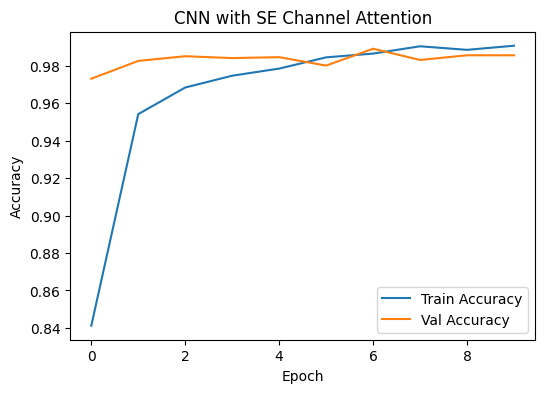

In [30]:
# Plot accuracy curves
plt.figure(figsize=(6, 4))
plt.plot(history_se.history['accuracy'], label='Train Accuracy')
plt.plot(history_se.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN with SE Channel Attention')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()